In [38]:
import pfTent as tent
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import scipy.stats as st
import pandas as pd

In [39]:
y=3
a = [10,10,10,10,10,10]
w = [0,1/5,1/5,1/5,1/5, 1/5]
eir=40
n_people = 100

In [40]:
fever,breaks = tent.load_data()
fever_arr = tent.get_fever_arr(eir,fever,breaks)
pmatrix, smatrix, imatrix, malaria,infectmatrix = tent.simulate_person(y,a,w,fever_arr)

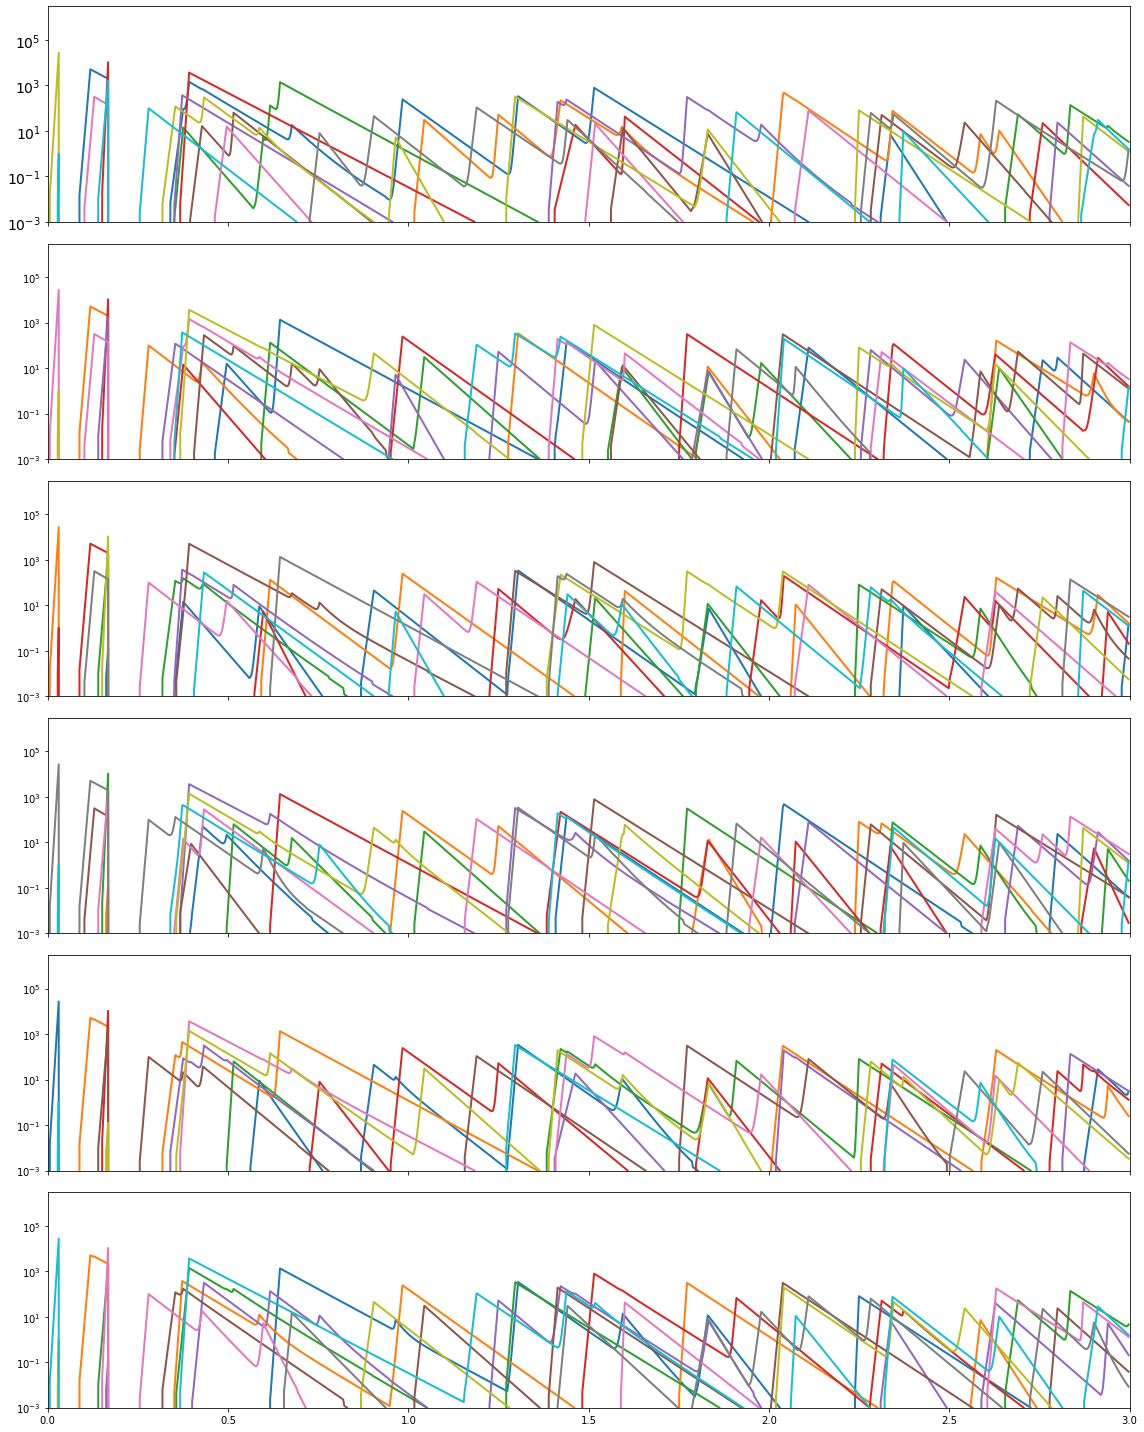

In [10]:
colors = {0:"tab:blue", 1:"tab:orange", 2:"tab:green", 3:"tab:red", 4:"tab:purple", 5:"tab:brown", 6:"tab:pink",7:"tab:olive",8:"tab:grey",9:"tab:cyan"}

fig, ax = plt.subplots(nrows=6, sharey=True, sharex=True, tight_layout=True, figsize=(16,20))
ax[0].tick_params(axis='both', which='major', labelsize=14)
#ax[1].tick_params(axis='both', which='major', labelsize=14)
ax[0].set_yscale('log')

ax[0].set_ylim(0.001,3000000)
ax[0].set_xlim(0,3)
for row in range(6):
    for strain in np.arange(10):
        iStrain = pmatrix[row,strain,:]
        if np.sum(iStrain) > 1:
            ax[row].plot(np.arange(y*365)/365, iStrain, linewidth=2,color=colors[strain])
            
#fig.savefig("../figs/oneperson_allloci.pdf")

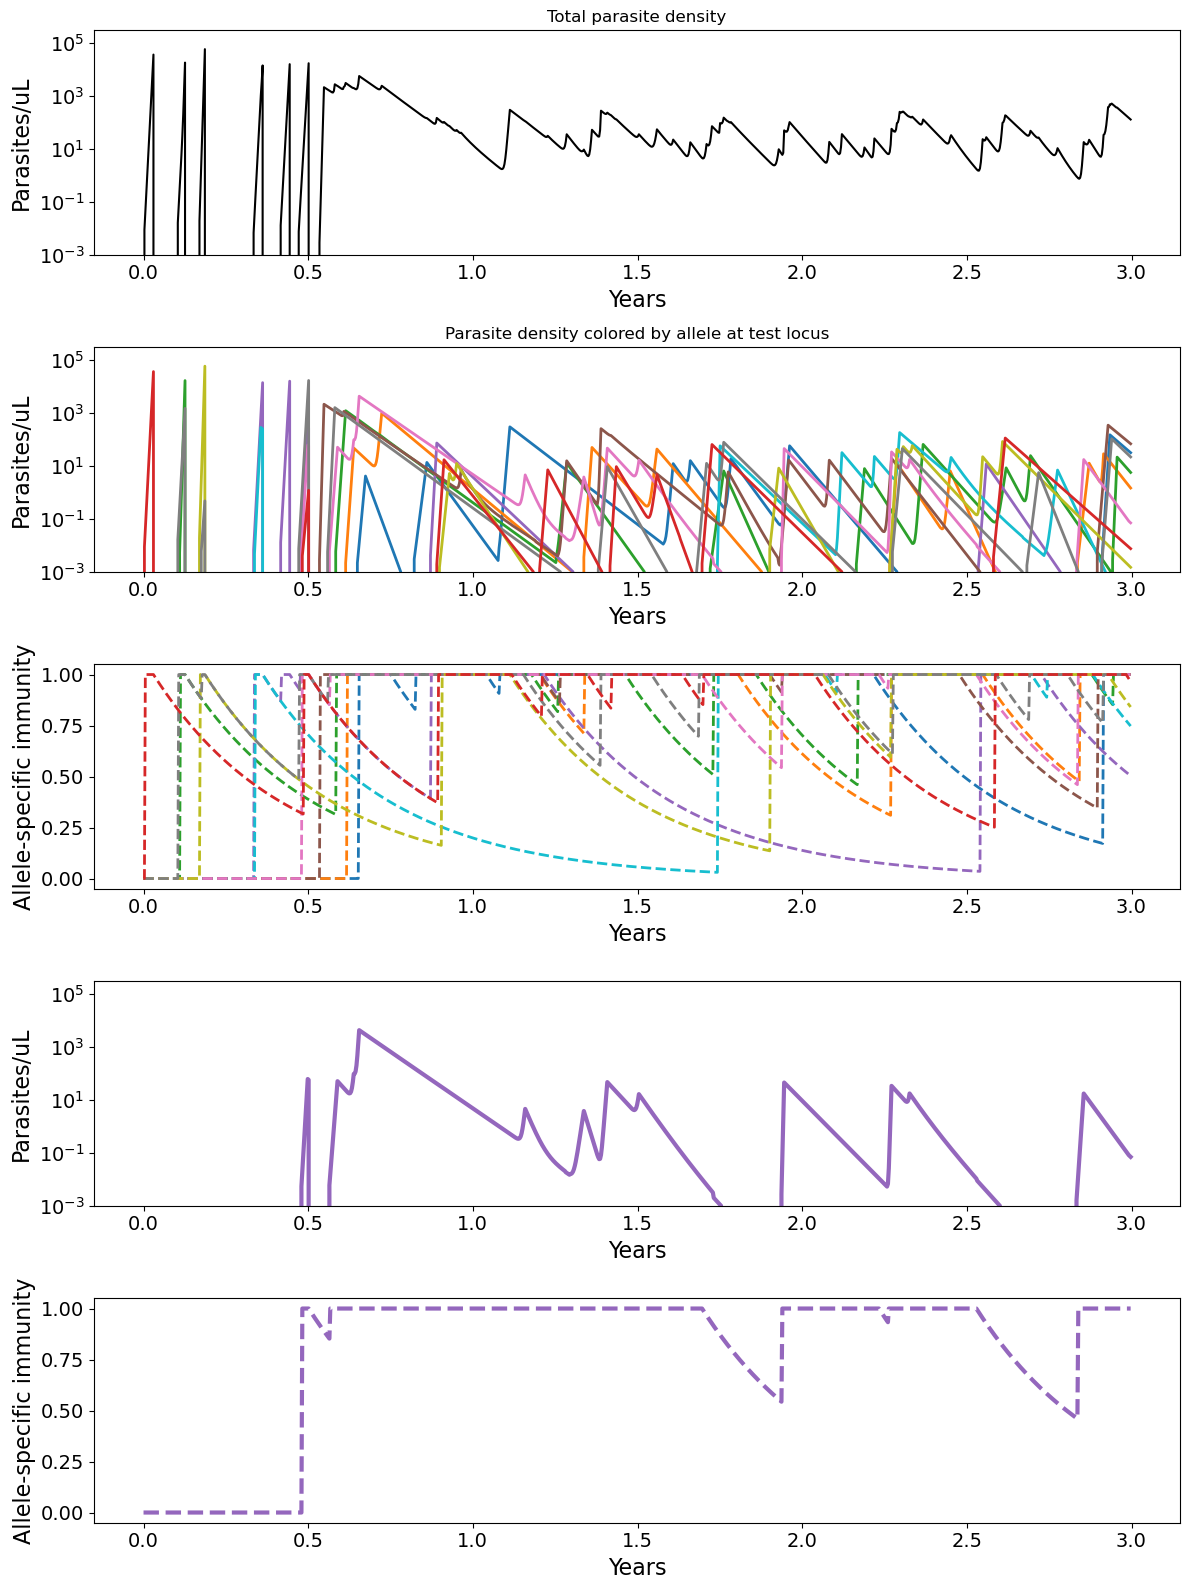

In [44]:
colors = {0:"tab:blue", 1:"tab:orange", 2:"tab:green", 3:"tab:purple", 4:"tab:cyan", 5:"tab:brown", 6:"tab:pink",7:"tab:olive",8:"tab:grey",9:"tab:red"}

fig, ax = plt.subplots(nrows=5,tight_layout=True, figsize=(12,16))
ax[0].tick_params(axis='both', which='major', labelsize=14)
ax[1].tick_params(axis='both', which='major', labelsize=14)
ax[0].set_yscale('log')
ax[3].set_yscale('log')
ax[1].set_yscale('log')
ax[0].plot(np.arange(y*365)/365, pmatrix[0,:,:].sum(axis=0),color="black")
for strain in np.arange(10):
    iStrain = pmatrix[0,strain,:]
    if np.sum(iStrain) > 1:
        ax[1].plot(np.arange(y*365)/365, iStrain, linewidth=2,color=colors[strain])
    iImmune = imatrix[0,strain,:]
    ax[2].plot(np.arange(y*365)/365,iImmune,linewidth=2,color=colors[strain],linestyle="dashed")
ax[0].set_ylim(0.001,300000)
ax[1].set_ylim(0.001,300000)
ax[3].set_ylim(0.001,300000)
for i in range(5):
    ax[i].set_xlabel('Years',fontsize=16)
ax[0].set_ylabel('Parasites/uL',fontsize=16)
ax[0].set_title('Total parasite density')
ax[1].set_title('Parasite density colored by allele at test locus')
ax[1].set_ylabel('Parasites/uL',fontsize=16)
ax[2].tick_params(axis='both',which='major',labelsize=14)
ax[3].tick_params(axis='both',which='major',labelsize=14)
ax[4].tick_params(axis='both',which='major',labelsize=14)
ax[3].set_ylabel('Parasites/uL',fontsize=16)
ax[2].set_ylabel('Allele-specific immunity',fontsize=16)
ax[4].set_ylabel('Allele-specific immunity',fontsize=16)
ax[3].plot(np.arange(y*365)/365, pmatrix[0,6,:],linewidth=3,color="tab:purple")
ax[4].plot(np.arange(y*365)/365,imatrix[0,6,:],linewidth=3,color="tab:purple",linestyle="dashed")

fig.savefig("../figs/control_intuition.pdf")


In [27]:
def modulate_params(gtype, strain_imm, params, w,xh=0.5,b=-1):
    '''
    Changes all infection params according to immunity:
        gtype = genotype vector for infection
        strain_imm = strain_immunity at time of infection
        params = params vector to modulate
        w = vector modulating immunity effect at locus
    '''
    n_loci = len(gtype)
    cross = strain_imm[np.arange(n_loci),(gtype)]
    totimm = np.sum(cross*w)
    cross_M = np.broadcast_to(cross,(4,n_loci))
    pw_M = np.broadcast_to(w,(4,n_loci)) * np.broadcast_to(params[:,None],(4,n_loci))
    M = tent.sigmoid(cross_M,pw_M,xh=xh,b=b)
    modified = M.sum(axis=1)
    modified[2] = params[2]
    modified[0] = np.rint(modified[0])
    return modified, totimm

def simulate_person(y,a,w,fever_arr, eir=40, t12=100,immune_thresh=0.01,duration = 500, meroz = .01, timeToPeak = 10, maxParasitemia = 6, pgone=-3,power=0,xh=0.5,b=-1):
    '''
    Runs simulation for one person.
    Returns:
    - matrix of parasitemia by allele across time
    - matrix of strains across time
    - matrix of immunity by allele across time
    - matrix of infection starts + gtype of infection by day. Size is
    (1+len(loci),n_infections). The first row is the day of the infection. The
    remaining rows are the gtype of the infection.
    '''
    malaria = []
    bites = tent.simulate_bites(y,eir)
    n_bites = len(bites)
    strains = tent.simulate_strains(n_bites,a,power)
    params_matrix = tent.simulate_params(n_bites,duration,meroz,timeToPeak,maxParasitemia)
    pmatrix = tent.create_allele_matrix(a, y)
    smatrix = tent.create_strain_matrix(n_bites,y)
    imatrix = tent.create_allele_matrix(a,y)
    infections = {}
    infections["day"] = []
    infections["gtype"] = []
    total_immunity = []
    times = []

    counter = 0
    for t in range(365*y):
        tent.update_immunity(pmatrix,imatrix,t,immune_thresh, t12)
        treatment_thresh = tent.get_fever_threshold(fever_arr,t)
        malaria = tent.treat_as_needed(treatment_thresh,pmatrix,smatrix,t,malaria)
        if t in bites:
            if not len(malaria) > 0 or t - malaria[-1] > 7:
                locs = np.where(bites == t)
                for i in locs[0]:
                    params = params_matrix[:,i]
                    params,totImm = modulate_params(strains[:,i], imatrix[:,:,t], params, w,xh=xh,b=b)
                    total_immunity.append(totImm)
                    times.append(t)
                    if params[0] > 0 and params[3] > 0 and params[1] > 0.001 and params[0] > params[2] and params[2] > 0:
                        parasitemia = tent.get_parasitemia(params, pgone)
                        tent.add_infection(parasitemia,pmatrix,strains[:,i],t,smatrix,i)
                        infections["day"].append(t)
                        infections["gtype"].append(strains[:,i])

    n_infect = len(infections["day"])
    infectmatrix = np.zeros((1+len(a),n_infect),dtype=int)
    for i, day in enumerate(infections["day"]):
        infectmatrix[0,i] = day
        infectmatrix[1:,i] = infections["gtype"][i]
    smatrix = smatrix[~np.all(smatrix == 0, axis=1)]
    return pmatrix, smatrix, imatrix, malaria, infectmatrix,times,total_immunity

def simulate_cohort(n_people,y,a,w,t12=100,eir=40,immune_thresh=0.01,duration=500,meroz=0.1,timeToPeak=10,maxParasitemia=6,pgone=-3,power=0,xh=0.5,b=-1):
    '''
    Simulates an entire cohort of individuals.

    Returns n_people x loci x alleles x t matrices tracking parasite density & immunity at each allele.
    Returns dictionary containing strain matrices for each person.
    Returns dictionary containing lists of malaria episodes for each person.
    Returns dictionary containing infection matrices for each person.

    Input:
        y = years to simulate
        a = vector of len(loci) specifying number of alleles at each locus
        w = immune weighting for each locus
        delta = immunity waning rate
    '''
    # Create objects to record
    all_parasites = np.zeros((n_people, len(a), max(a), y*365))
    all_immunity = np.zeros((n_people, len(a), max(a), y*365))
    all_strains = {}
    all_malaria = {}
    all_infections = {}
    tIMM = []
    BITES = []

    # Load dataset for fever threshhold
    fever, breaks = tent.load_data()
    fever_arr = tent.get_fever_arr(eir,fever,breaks)

    # Simulate people
    for person in range(n_people):
        pmatrix, smatrix, imatrix, malaria, infections,bites,total_immunity = simulate_person(y,a,w,fever_arr,eir=eir, t12=t12,immune_thresh=immune_thresh,duration=duration, meroz=meroz, timeToPeak=timeToPeak, maxParasitemia=maxParasitemia, pgone=pgone,power=power,xh=xh,b=b)
        all_parasites[person,:,:,:] = pmatrix
        all_immunity[person,:,:,:] = imatrix
        all_strains[person] = smatrix
        all_malaria[person] = malaria
        all_infections[person] = infections
        tIMM.extend(total_immunity)
        BITES.extend(bites)

    return all_parasites, all_immunity, all_strains, all_malaria, all_infections,tIMM,BITES

In [35]:
y=5
all_parasites, all_immunity, all_strains, all_malaria, all_infections,totImm,Bites = simulate_cohort(n_people,y,a,w,t12=100,xh=0.5,immune_thresh=0.01)

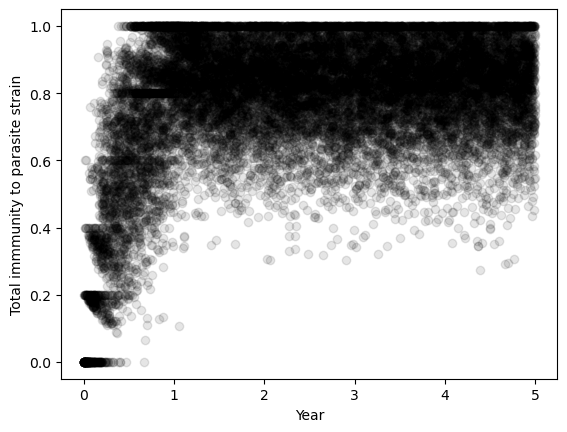

In [36]:
fig, ax = plt.subplots()
ax.plot(np.asarray(Bites)/365,totImm, 'ko',alpha=0.1)
ax.set_ylabel('Total immmunity to parasite strain')
ax.set_xlabel('Year')

fig.savefig("immunity_time.pdf")